# Segment Anything with Python for Microscopy Images

**Objective:** In this workshop, we'll explore the Segment Anything (SAM) model, a cutting-edge segmentation model based on Vision Transformers (ViT), introduced by Meta in April 2023. SAM was trained using 1 billion masks from 11 million diverse images. The model focuses primarly on natural images known for their pronounced edge details but actually stands out for its ability to perform zero-shot segmentation across a wide range of images including biological and medical image data. As of October 21, 2024, SAM has gained significant recognition, cited in over 6,000 publications, and inspired various adaptations for specific fields.

Designed with biologists, microscopists, and bio-image analysts in mind, this workshop focuses on leveraging SAM for biological imagery. We will guide you through using SAM within Python, employing examples from biology to illustrate its applications. The present materials support the workshop titled 'Segment Anything with Python for Microscopy Images' organized by Harvard Medical School's Image Analysis Collaboratory in 2024.

By this short worksho, we aim for you to gain a thorough understanding of SAM's mechanics, how to apply it to your projects, and its potential and limitations within your field.

# Chapter 1: Introduction to SAM


## **Introduction:**

Segment Anything Model (SAM) is a foundation model [1] developed by Meta AI and introduced in the paper Segment Anything [2]. In this paper, authors have introduced a vision transformer-based foundation model for zero-shot segmentation tasks. One of the main powerful features of the model is that it is promptable using boxes, points, masks, or texts. SAM was trained with 1 billion masks from 11 million images. Significant testing showed that SAM performs better than a lot of fully supervised models and fine tuning SAM with specific tasks can lead to even more accurate results. Since the publication in April 2023, multiple different papers have been published in different fields such as medical imaging [3], and biological imaging [4, 5] that use SAM as a base model to segment their specific images.


## **Model Architecture:**

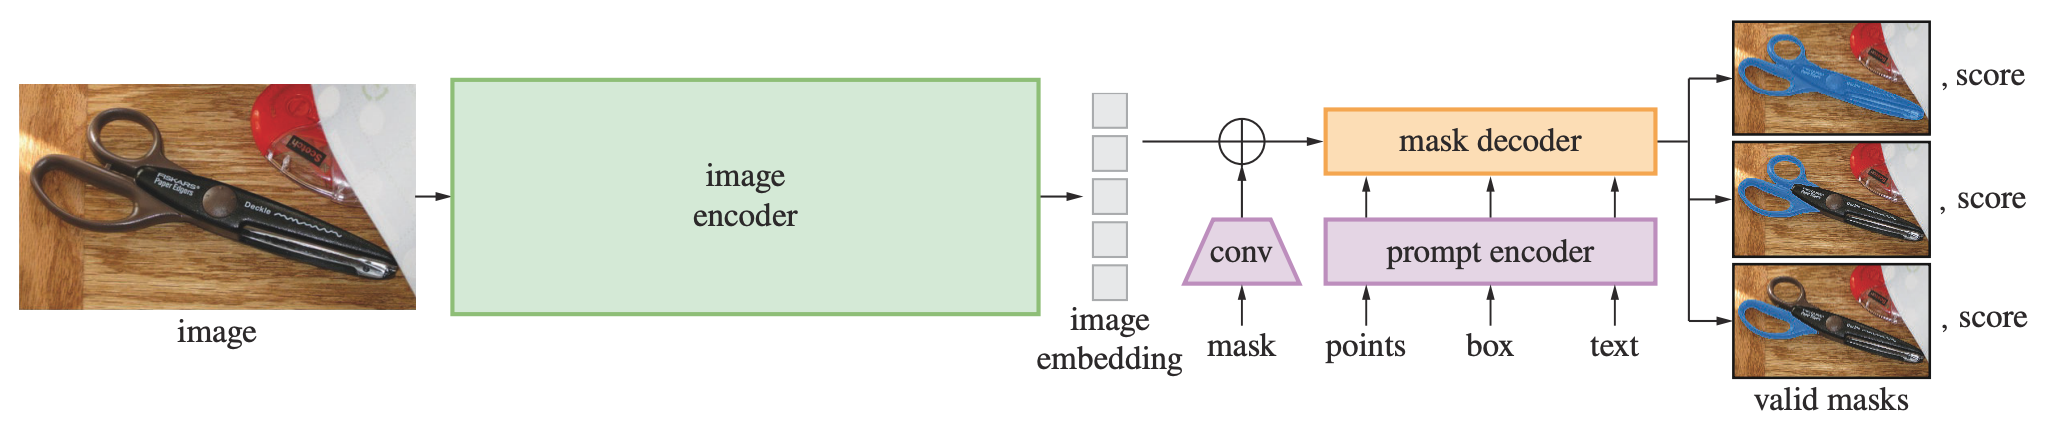

_(Source: Segment Anything [2])_

Above is the model architecture of SAM. It has three main building blocks: **image encoder**, **prompt encoder**, and **mask decoder**.

**Image encoder:** This block uses Vision Transformer (ViT) [6], pre-trained with Masked Autoencoder (MAE) [7] to create the image embedding. While this is the most time and resource consuming operation, it is run only once per image.

**Prompt encoder:** This block uses two sets of prompts: sparse prompts in the form of points, boxes and text, and dense prompts in the form of masks. Points and boxes are encoded using positional encodings [8], combined with unique learned embeddings for each type of sparse prompt. Free-form text is processed using a standard text encoder from CLIP [9]. For dense prompts, convolutional methods are used to embed them, and these embeddings are then integrated with the image embedding through element-wise summation.

**Mask decoder:** The mask decoder effectively transforms the image embedding, prompt embeddings, and an output token into a mask through a modified Transformer decoder block [10], followed by a dynamic mask prediction mechanism.

## **Model Checkpoints:**

In the beginning, SAM was trained with public, annotated datasets. As more annotations were created using SAM, new annotations were used to retrain SAM. Three model versions with different backbone sizes were made available which are ViT-B, ViT-L, and ViT-H where ViT-B is the base model and ViT-H is the biggest model. Model size significantly increased from ViT-B to ViT-H, so did the model's performance. However, ablation study showed that the performance increase between ViT-L and ViT-H is minimal as showed in the figure below. Hence, based on a given task, using the model ViT-L might just be sufficient.

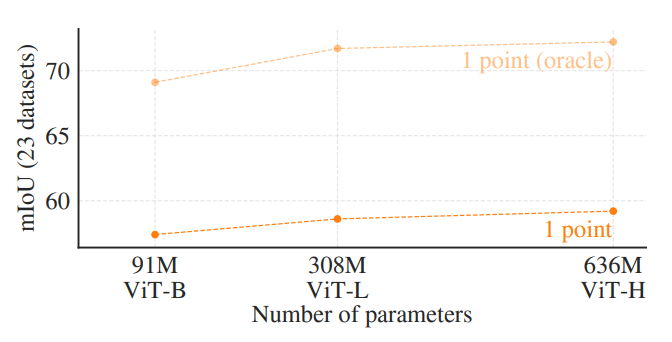

_(Source: Segment Anything [2])_
\
\
Model checkpoints can be downloaded from [here](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints).

# Chapter 2: Setting up SAM to run locally


Before we get started, it is important to ensure that the your Python environment is setup to run SAM and you have all the files necessary locally to follow along.

## Chapter 2.1: Check the conda environment

In [46]:
def print_warning(message):
    WARNING_COLOR = '\033[93m'  
    RESET_COLOR = '\033[0m'     
    print(f"{WARNING_COLOR}{message}{RESET_COLOR}")

def print_error(message):
    ERROR_COLOR = '\033[31m'  
    RESET_COLOR = '\033[0m'     
    print(f"{ERROR_COLOR}{message}{RESET_COLOR}")

print_warning("This is a warning message")
print_error("This is an error message")

[93mThis is a warning message[0m

[31mThis is an error message[0m

In [17]:
import os

print(f"Selected conda environment: {os.environ['CONDA_DEFAULT_ENV']}")

Selected conda environment: sam


Check if all the necessary packages are installed or not:
```segment_anything```, ```torch```, ```matplotlib```, ```cv2```

In [18]:
required_libraries = ['segment_anything', 'torch', 'matplotlib', 'cv2']

for lib in required_libraries:
    try:
        __import__(lib)
        print(f"{lib} is installed.")
    except ImportError:
        print_error(f"{lib} is NOT installed.")

segment_anything is installed.
torch is installed.
matplotlib is installed.
cv2 is installed.


Check if all the necessary files are present:

1. ```images/1.jpg```
2. ```model-checkpoint/sam_vit_h_4b8939.pth```

In [19]:
required_files = ['images/1.jpg', 'model-checkpoint/sam_vit_h_4b8939.pth']

for file in required_files:
    if os.path.exists(file):
        print(f"{file} is present.")
    else:
        print_error(f"{file} is NOT present.")

images/1.jpg is present.
model-checkpoint/sam_vit_h_4b8939.pth is present.


## Chapter 2.2: Functions for visualization visualize

Some of the visualization code that I wrote for quick visualization of the results. These are Open-CV, matplotlib based functions. For the fast pace of the workshop we are not going to write it together, but we will use them. You are welcome to review them and ask me any questions you have.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Functtion to display an image
def display_image(image):
  fig, ax = plt.subplots(figsize=(5,5))
  ax.imshow(image, cmap='gray')
  ax.axis('off')

# Display bounding boxes around all the objects detected
def display_image_with_bounding_boxes(image, masks):
  fig, ax = plt.subplots(figsize=(5,5))

  ax.imshow(image)
  ax.axis('off')

  for mask in masks:
    x,y,w,h = mask['bbox']
    ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

def display_image_with_overlay(image, masks, color=[255, 255, 0], thickness=1):
  img = np.copy(image)

  for mask in masks:
    contours, _ = cv.findContours(mask['segmentation'].astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(img, contours, -1, color=color, thickness=thickness)

  display_image(img)

# Display individual masks and IoU scores
def display_image_with_individual_overlay(image, masks, score):
  plt.figure(figsize=(5,5))

  img = np.copy(image)

  contours, _ = cv.findContours(masks.astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  cv.drawContours(img, contours, -1, color=[255, 255, 0], thickness=1)

  plt.imshow(img)
  plt.title(f"IoU: {score:.4f}")
  plt.axis('off')



# Chapter 3: Segment Everything with SAM

In this module, we will dive into a hands-on experience with the SAM. We'll explore how to load the model into our working memory, and utilize it for segmenting each object of interest within an image. This will also include an overview of various input parameters that you can adjust to tailor the segmentation process.

In [43]:
# Import libraries
import cv2 as cv
import torch
import matplotlib.pyplot as plt
from rich import print

## Chapter 3.1: Segment all the objects in an image

In [22]:
# Load an image
image_path = "images/1.jpg"
image = cv.imread(image_path)

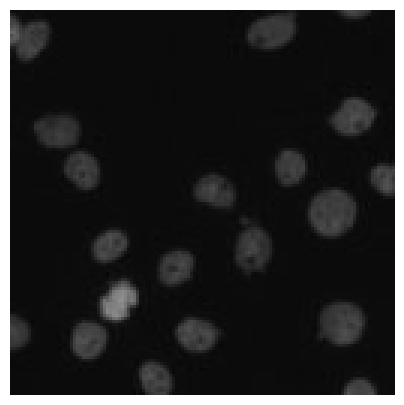

In [23]:
# Display the image
display_image(image)

In [24]:
print(f"Image shape: {image.shape}")

Image shape: (128, 128, 3)


In [25]:
print(f"Image data type: {image.dtype}")

Image data type: uint8


In this module, we will use SAM in its default settings to see how it identifies each object present in the image and segments them. We will also investigate the output to see what information we can extract from it.

In [26]:
# Import SAM
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry

The step below is where SAM is loaded into the memory hence depending on the speed and memory capacity, this may take a moment.

In [45]:
# Load SAM model
checkpoint_path = "model-checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU.")
else:
    device = "cpu"
    print_warning("Using CPU.")

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)

# SAM for automatic mask generation
mask_generator = SamAutomaticMaskGenerator(sam)


[93mUsing CPU.[0m

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
  )
  (prompt_encoder): PromptEncoder(
    (pe_layer): PositionEmbeddingRandom()
    (point_embeddings): ModuleList(
      (0-3): 4 x Embedding(1, 256)
    )
    (not_a_point_embed): Embedding(1, 256)
    (mask_downscaling): Sequential(
      (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
      (1): LayerNorm2d()
      (2): GELU(approximate='none')
      (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
      (4): LayerNorm2d()
      (5): GELU(approximate='none')
      (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (no_mask_embed): Embedding(1, 256)
  )
  (mask_decoder): MaskDecoder(
    (transformer): TwoWayTransformer(
      (layers): ModuleList(
        (0-1): 2 x TwoWayAttentionBlock(
          (self_attn): Attention(
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (cross_attn_token_to_image): Attention(
            (q_proj): Linear(in_features=256, out_features=128, bias=True)
            (k_proj): Linear(in_features=256, out_features=128, bias=True)
            (v_proj): Linear(in_features=256, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=256, bias=True)
          )
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=256, out_features=2048, bias=True)
            (lin2): Linear(in_features=2048, out_features=256, bias=True)
            (act): ReLU()
          )
          (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (cross_attn_image_to_token): Attention(
            (q_proj): Linear(in_features=256, out_features=128, bias=True)
            (k_proj): Linear(in_features=256, out_features=128, bias=True)
            (v_proj): Linear(in_features=256, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=256, bias=True)
          )
        )
      )
      (final_attn_token_to_image): Attention(
        (q_proj): Linear(in_features=256, out_features=128, bias=True)
        (k_proj): Linear(in_features=256, out_features=128, bias=True)
        (v_proj): Linear(in_features=256, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=256, bias=True)
      )
      (norm_final_attn): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (iou_token): Embedding(1, 256)
    (mask_tokens): Embedding(4, 256)
    (output_upscaling): Sequential(
      (0): ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): LayerNorm2d()
      (2): GELU(approximate='none')


Let us first start with the default settings. Later, we will see what input parameters can improve the segmentation result.

In [43]:
# Generate mask


Now as it created `masks`, let us investigate what outputs do we get:

**Q. What datastructure is `masks`?**

list

**Q. What is the length of masks?**

28

So, SAM detected 28 objects in the image.

**Q. What data structure is individual items inside `masks`?**

dict

**Q. What are the keys of each dictionar?**

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

So `masks`, the output of the generator function is a list of dictionaries where each dictionary contains a mask for each object it detected and segmented inside the image.

`segmentation`: Binary segmentation mask. \
`area`: This is the total number of pixels within the segmentation mask. It gives us a quantifiable size of the area covered by the mask. \
`bbox`: The bounding box is a rectangular box that frames the boundaries of the mask. It is defined in XYWH format, where 'X' and 'Y' represent the coordinates of the box's top-left corner, and 'W' and 'H' specify the width and height of the box, respectively. \
`predicted_iou`: This is the model's prediction of the mask's accuracy. It measures the overlap between the predicted mask and the actual area it's supposed to cover. A higher IOU indicates a more accurate mask. \
`point_coords`: These are the coordinates of the specific point that was used to generate the mask. It's the starting point from which the mask was developed. \
`stability_score`: This is an additional metric to assess the quality of the mask. It evaluates how consistent and reliable the mask is across various conditions or inputs. \
`crop_box`: This is the section of the original image that was used to generate the mask. Like the bounding box, it's defined in XYWH format and specifies the area of interest from which the mask was created.

Now let us use `bbox` to draw bounding box around detected objects.

In [48]:
# Display segmentation using bounding box


[8, 34, 15, 11]


With this, let us create a function that takes the image and the list of dictionaries as input and draws bounding boxes around all objects it found. This is going to be useful for future visualization tasks.

In [2]:
# Display image with bounding boxes


## Chapter 3.2: Improve the results using input parameters

We noticed a couple of issues with the previoous segmentation result:
1. It is creating overlaping masks
2. It is detecting areas that are too small to be our region of interest

**Q. What input parameters do the automatic mask generator accept?**

**SamAutomaticMaskGenerator()** method has the following input arguments: \
`model`: The SAM model \
`points_per_side`: Number of points sampled along each side of the image, resulting in a total of (points_per_side)<sup>2</sup> points. If set to 'None', specify explicit point sampling in 'point_grids'. _(default: 32)_ \
`points_per_batch`: This parameter controls how many points the model processes at once. Increasing this number can speed up the process but will require more GPU memory. _(default: 64)_ \
`pred_iou_thresh`: Sets a threshold between 0 and 1 for filtering based on the predicted mask quality. _(default: 0.88)_ \
`stability_score_thresh`: Another filtering threshold, also between 0 and 1, focuses on the mask's stability under variations in the cutoff for binarizing mask predictions. _(default: 0.95)_ \
`stability_score_offset`: Adjusts the cutoff value used in calculating the stability score. _(default: 1.0)_ \
`box_nms_thresh`: Determines the cutoff for the Intersection over Union (IoU) in non-maximum suppression, which helps filter out duplicate masks. _(default: 0.7)_ \
`crop_n_layers`: If greater than 0, the mask prediction will be re-run on cropped sections of the image. The number of layers defines how many rounds of cropping occur, with each layer having an increasing number of image crops. _(default: 0)_ \
`crop_nms_thresh`: Similar to the box NMS threshold, this is used for filtering duplicates in different image crops. _(default: 0.7)_ \
`crop_overlap_ratio`: Defines the overlap between crops. In the initial layer, the crops overlap by this specified fraction of the image length, with the overlap decreasing in subsequent layers. _(default: 512 / 1500)_ \
`crop_n_points_downscale_factor`: The points-per-side sampled in each crop layer are scaled down by this factor. _(default: 1)_ \
`point_grids`: An optional list of explicit point grids for sampling, normalized to the range [0,1]. Each grid corresponds to a crop layer. This parameter is used instead of 'points_per_side'. _(default: None)_ \
`min_mask_region_area`: Sets a minimum area threshold for mask regions. Post-processing is applied to eliminate disconnected regions or holes in masks smaller than this area. Requires OpenCV. _(default: 0)_ \
`output_mode`: Choose how masks are returned. Options include 'binary_mask', 'uncompressed_rle', or 'coco_rle'. Note: 'coco_rle' requires pycocotools, and 'binary_mask' may consume significant memory at large resolutions. _(default: "binary_mask")_ 

**Q. Is there an input parameters that can be changed to remove overlapping masks?**

Yes, `box_nms_thresh`. Lower value of `box_nms_threshold` will result in less overlapping segments and higher value of `box_nms_threshold` will result in higher overlapping segments.

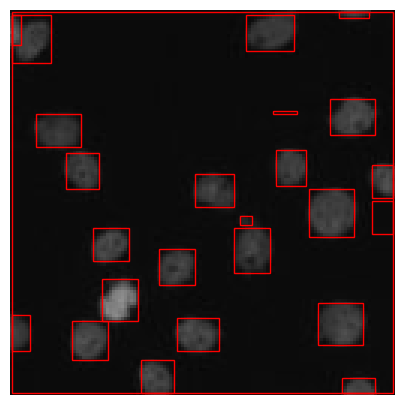

In [50]:
# Generate masks with lower box_nms_thresh value


Lowering the value of `box_nms_threshold` removed all the overlapping segmentations.

**Q. How many objects did it detect now?**

25

The overlapping segmentaiton improved significantly. Now we can also filter by low area.

In [3]:
# Print all the values of area


First item is a clear outlier and it is the whole image. If we remove that and plot the rest of the areas, we will get a good idea of the distribution. In most cases, we know the size of our object of interest. That _a priori_ information, along with the distribution, can be used to determine the range within which the object of interest lies. If the size of the object is unknown, the distribution can still be used to remove any outliers and filter out masks by area.

(array([4., 1., 3., 3., 8., 3., 2., 1., 0., 2.]),
 array([ 16. ,  44.7,  73.4, 102.1, 130.8, 159.5, 188.2, 216.9, 245.6,
        274.3, 303. ]),
 <BarContainer object of 10 artists>)

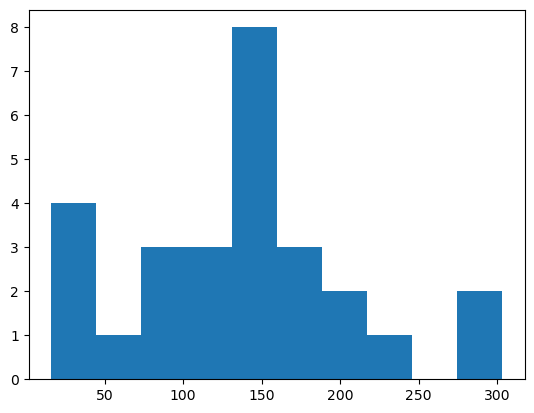

In [53]:
# Plot areas


Looks like anything between 100 and 250 is a good estimate.

Now let us modify the previous display function to accept minimum and maximum area thresholds and filter the output accordingly.

In [54]:
# Write a function to filter area
def filter_mask_by_area(masks, max_area, min_area):
  filtered_mask = []

  for mask in masks:
    area = mask['area']
    if (area > min_area) and (area < max_area):
      filtered_mask.append(mask)

  return filtered_mask

In [4]:
# Filter and display filtered masks

**Q. How many objects do we have in the segmentation now?**

## Chapter 3.3: Displaying Segment Masks - Instances

We can now look at individual instances using the key ```segmentation```.

In [5]:
# Display single instance mask

In [6]:
# Display all instance masks

Similarly, let us now visualize overlays across all the objects.

In [7]:
# Display all instance masks with overlay

# Chapter 4: Segment objects with Prompts


## Chapter 4.1: Points

In this module, we will learn about how to prompt SAM with the coordinates of each object (points) and let it create the segmentation around that object. This is especially useful when we know the locations of the objects, or we want to simply click on the objects we want to segment and create precise segmentation.

Let us first identify the location of a cell in the image below.

In [8]:
# Display the image and get some points for some of the objects


In [9]:
# Load the image into SAM


In [10]:
# Create segmentation for the object at the location


Above, we can provide multiple different points as input and also whether they are foreground or background. The parameter `multimask_output` is set to `True` which by default returns 3 outputs with IoU scores. We can modify the function to retrieve more than 3 outputs. However, we will soon see that in most cases we will not need more than 3 outputs.

In [11]:
# Display mask

In [12]:
# Display indiidual masks and IoU scores associated


Similarly, we can set the `multimask_output` to `False` which will result in only a single output mask. Please note that it does not by default give the mask with highest score, instead it somehow averages them for predicting the final output.

In [78]:
input_point = np.array([[82,78]])
input_label = np.array([1]) #1: foreground, 0:background

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [79]:
len(masks)

1

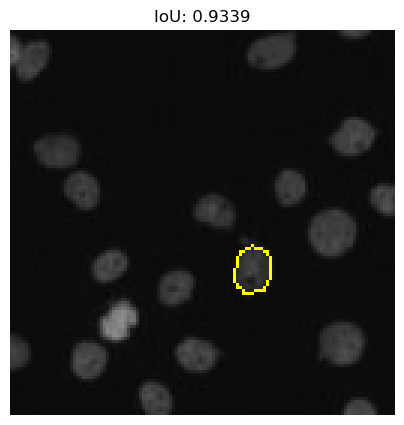

In [80]:
display_image_with_individual_overlay(image, masks[0], scores[0])

## Chapter 4.2: Bounding Boxes

Now we would try the same with bounding boxes. Instead of points, we can also have bounding boxes as prompts to SAM.

In [13]:
# Draw bounding box aorund an object


In [14]:
# Generate multiple masks


In [15]:
# Display indiidual masks and IoU scores associated


In [84]:
# Generate a single masks
input_box = np.array([70,70,90,90])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

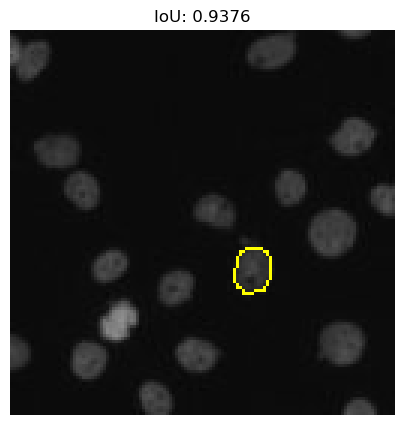

In [85]:
# Display indiidual masks and IoU scores associated
display_image_with_individual_overlay(image, masks[0], scores[0])

# Chapter 5: Few other examples



## Early zebrafish embryo cells

This slice was extracted from a 7-hour post-fertilization (hpf) time-lapse 3D stack image capturing the development of a zebrafish embryo. The nuclei are stained with mCherry, while the membranes are stained with GFP. Magnification: 40x.

*Courtesy of Rikki Garner, PhD.*

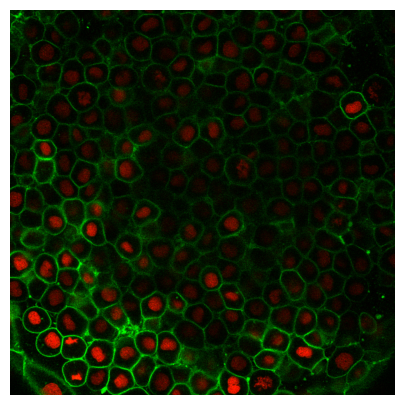

In [86]:
# Load an image
image_path = 'images'
image_name = '2.png'
image = cv.imread(f'{image_path}/{image_name}')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

display_image(image)

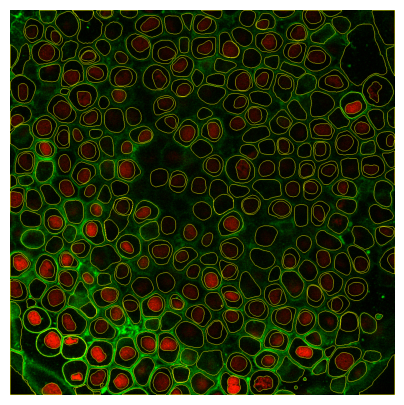

In [87]:
# Load SAM model
sam_checkpoint = "model-checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# Generate mask
masks = mask_generator.generate(image)

# Display results
display_image_with_overlay(image, masks)

## Cellpose

Cellpose [11] is a deep learning based generalist cell segmentation algorithm. Below is an image randomly selected from the Cellpose test dataset that is publicly available.

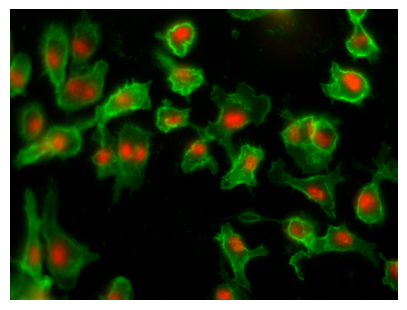

In [88]:
# Load an image
image_path = 'images'
image_name = '3.png'
image = cv.imread(f'{image_path}/{image_name}')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

display_image(image)

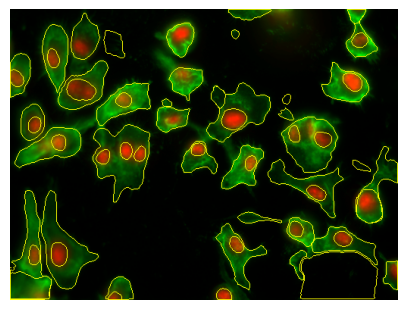

In [90]:
# Load SAM model
sam_checkpoint = "model-checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.3)

# Generate mask
masks = mask_generator.generate(image)

# Display results
display_image_with_overlay(image, masks, color=[255,255,0], thickness=1)


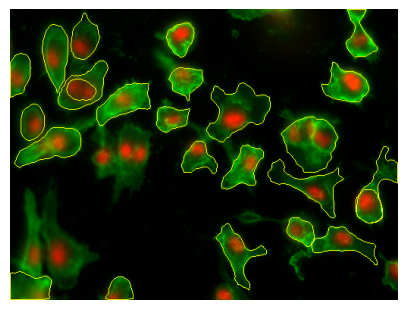

In [110]:
masks_filtered = filter_mask_by_area(masks, max_area=4000, min_area=800)
display_image_with_overlay(image, masks_filtered)

## Normalized Raman Imaging:

Composit image of a mouse kidney imaged using Normalized Raman Imaging (NoRI) [12] and fluorescence microscopy.

*(Courtesy of Will Trim, PhD)*

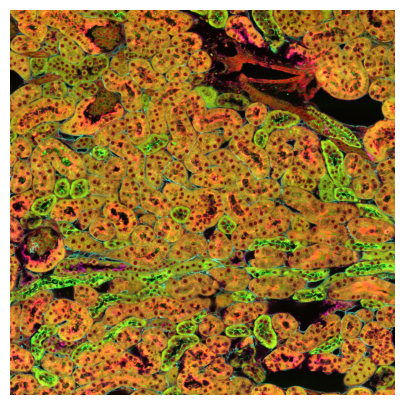

In [117]:
# Load an image
image_path = 'images'
image_name = '5.png'
image = cv.imread(f'{image_path}/{image_name}')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

display_image(image)

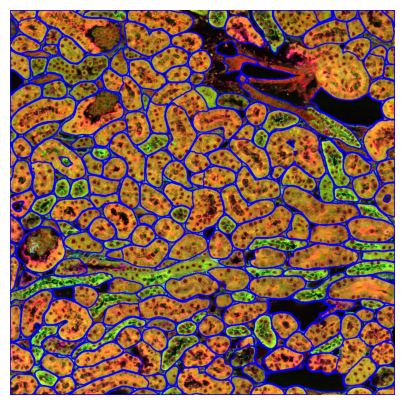

In [118]:
# Load SAM model
sam_checkpoint = "model-checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.3)

# Generate mask
masks = mask_generator.generate(image)

# Display results
display_image_with_overlay(image, masks, color=[0,0,255], thickness=2)

# Chapter 6: Conclusion

Congratulations on completing the course on "Segment Anything using Python for Microscopy Data"! Throughout this course, we have delved into the powerful capabilities of SAM, setting up your environment, running segmentation tasks, and fine-tuning the process for precision. We have explored how SAM can be adapted to a wide range of images, showcasing its versatility and effectiveness in bio-image analysis.

We hope this course gave you the knowledge and skills to leverage SAM for your specific research needs, opening new avenues for exploration in your field. Thank you for taking this journey with us and we hope you found it useful.

# APPENDIX:

## References

[1] Bommasani, R., Hudson, D.A., Adeli, E., Altman, R., Arora, S., von Arx, S., Bernstein, M.S., Bohg, J., Bosselut, A., Brunskill, E. and Brynjolfsson, E., 2021. On the opportunities and risks of foundation models. arXiv preprint arXiv:2108.07258. *(https://arxiv.org/abs/2108.07258)*


[2] Kirillov, A., Mintun, E., Ravi, N., Mao, H., Rolland, C., Gustafson, L., Xiao, T., Whitehead, S., Berg, A.C., Lo, W.Y. and Dollár, P., 2023. Segment anything. arXiv preprint arXiv:2304.02643. *(https://arxiv.org/abs/2304.02643)*


[3] Ma, J., He, Y., Li, F., Han, L., You, C. and Wang, B., 2024. Segment anything in medical images. Nature Communications, 15(1), p.654. *(https://www.nature.com/articles/s41467-024-44824-z)*

[4] Archit, A., Nair, S., Khalid, N., Hilt, P., Rajashekar, V., Freitag, M., Gupta, S., Dengel, A., Ahmed, S. and Pape, C., 2023. Segment anything for microscopy. bioRxiv, pp.2023-08. *(https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1)*

[5] Israel, U., Marks, M., Dilip, R., Li, Q., Schwartz, M.S., Pradhan, E., Pao, E., Li, S., Pearson-Goulart, A., Perona, P. and Gkioxari, G., 2023. A Foundation Model for Cell Segmentation. bioRxiv, pp.2023-11. *(https://arxiv.org/abs/2311.11004)*

[6] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929. *(https://arxiv.org/abs/2010.11929)*

[7] He, K., Chen, X., Xie, S., Li, Y., Dollár, P. and Girshick, R., 2022. Masked autoencoders are scalable vision learners. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 16000-16009). *(https://arxiv.org/abs/2111.06377)*

[8] Tancik, M., Srinivasan, P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. and Ng, R., 2020. Fourier features let networks learn high frequency functions in low dimensional domains. Advances in Neural Information Processing Systems, 33, pp.7537-7547. *(https://arxiv.org/abs/2006.10739)*

[9] Radford, A., Kim, J.W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J. and Krueger, G., 2021, July. Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748-8763). PMLR. *(https://arxiv.org/abs/2103.00020)*

[10] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I., 2017. Attention is all you need. Advances in neural information processing systems, 30. *(https://arxiv.org/abs/1706.03762)*

[11] Stringer, C., Wang, T., Michaelos, M. and Pachitariu, M., 2021. Cellpose: a generalist algorithm for cellular segmentation. Nature methods, 18(1), pp.100-106. *(https://www.nature.com/articles/s41592-020-01018-x)*

[12] Oh, S., Lee, C., Yang, W., Li, A., Mukherjee, A., Basan, M., Ran, C., Yin, W., Tabin, C.J., Fu, D. and Xie, X.S., 2022. Protein and lipid mass concentration measurement in tissues by stimulated Raman scattering microscopy. Proceedings of the National Academy of Sciences, 119(17), p.e2117938119. *(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9169924/)*

## Data Sources

Nuclei image used for the workshop and the exercise was downloaded from Broad Institute.

## FAQs:

* **Can you change the number of multimask outputs?** - Yes! In the mask_decoder, it is defined as 3, which can changed by editing the code.


## Resources for further reading:

**[Can SAM Segment Anything? When SAM Meets Camouflaged Object Detection](https://arxiv.org/abs/2304.04709)**


**[SAM-Adapter: Adapting Segment Anything in Underperformed Scenes](https://openaccess.thecvf.com/content/ICCV2023W/VCL/html/Chen_SAM-Adapter_Adapting_Segment_Anything_in_Underperformed_Scenes_ICCVW_2023_paper.html)**


**[Segment Anything Model (SAM) for Digital Pathology: Assess Zero-shot Segmentation on Whole Slide Imaging](https://arxiv.org/abs/2304.04155)**


**[Medical SAM Adapter: Adapting Segment Anything Model for Medical Image Segmentation](https://arxiv.org/abs/2304.12620)**


**[When Foundation Model Meets Federated Learning: Motivations, Challenges, and Future Directions](https://arxiv.org/abs/2306.15546)**


**[Segment Anything for Microscopy](https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1)**


**[Segment Anything – A Foundation Model for Image Segmentation](https://learnopencv.com/segment-anything/)**


**[A Comprehensive Survey on Segment Anything Model for Vision and Beyond](https://github.com/liliu-avril/Awesome-Segment-Anything#paper-list)**


**[Segment Anything Model with 🤗Transformers](https://keras.io/examples/vision/sam/)** - _Tensorflow_


**[Unraveling the Segment Anything Model (SAM)](https://appsilon.com/segment-anything-model-computer-vision/)**


**[Transformers in Vision: A Survey](https://arxiv.org/pdf/2101.01169.pdf)**


**[Meta AI's New Breakthrough: Segment Anything Model (SAM) Explained](https://encord.com/blog/segment-anything-model-explained/)**
